# Feed-down calculator

In the following Jupyter Notebook we implement the equations derived  by Dr. Mazeliauskas to compute the feed-down generated from a particle $a$ to a particle $b$ due to the decay $a\to bc$.

In [2]:
#nummerical methods
import numpy as np
import scipy.integrate as integrate
from scipy.special import ellipk
from scipy.special import ellipkinc
#data analysis
import pandas as pnd
import os
#handling of plots
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.close('all')
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

def getPstar(ma, mb, mc):
    try:
        term1 = (mc**2 - ma**2 - mb**2)**2
        term2 = 4*ma**2*mb**2
        if(term1 < term2):
            raise ValueError()
        elif ma==0:
            raise  ZeroDivisionError()
        return np.sqrt(term1-term2)/(2*ma)
    except ValueError:
        print("Warning: Negative square root encountered in p*. ")
        return np.nan
    except ZeroDivisionError:
        print("Warning: Invalid value passed for parent particle, ma = 0")
        return np.nan

def getEstar(ma, mb, mc):
    try: 
        return (ma**2 + mb**2 - mc**2)/(2*ma)
    except ZeroDivisionError:
        print("Warning: Invalid value passed for parent particle, ma = 0")
        return np.nan

def getmT(m, pT):
    return np.sqrt(m**2 + pT**2)

def get_qTplus(ma, mb, mc, pT):
    if mb != 0:
        pstar = getPstar(ma, mb, mc)
        mstarT = getmT(mb, pstar)
        mT = getmT(mb, pT)
        return ma/mb**2*(pT*mstarT + pstar*mT)
    else:
        return np.inf

def get_qTminus(ma, mb, mc, pT):
    tol = 1e-6
    pstar = getPstar(ma, mb, mc)
    mstarT = getmT(mb, pstar)
    mT = getmT(mb, pT)       
    if (mb==0):
        if (mc==0):
            return 2*(pT**2 - ma**2/4)/(2*pT)
        else:
        # dimensionless smallness check
        #scale = max(pT, pstar, ma)
        #if mb/scale < tol: #mb= 0 case with mc !=0
            # use small-mb expansion
            return ma*(pT**2 - pstar**2)/(2*pT*pstar)
    else:
        return ma/mb**2 * (pT*mstarT - pstar*mT)

def getAplus(qT, ma, mb, mc, pT):
    Estar = getEstar(ma, mb, mc)
    mqT = getmT(ma, qT)
    mpT = getmT(mb, pT)
    return (ma*Estar + mqT*mpT)/pT/qT

    
def getAminus(qT, ma, mb, mc, pT):
    Estar = getEstar(ma, mb, mc)
    mqT = getmT(ma, qT)
    mpT = getmT(mb, pT)
    return (-ma*Estar + mqT*mpT)/pT/qT

def integrand_factor_massive(qT, b, ma, mb, mc, pT, Debug = False): 
    try:
        pstar = getPstar(ma, mb, mc)
        norm = ma/pstar/np.pi*b
        am = getAminus(qT, ma, mb, mc, pT)
        ap = getAplus(qT, ma, mb, mc, pT)
        case_condition = (am <-1)
        #case for a_{-}<-1
        if (am < -1):
            if ((am + ap)/(ap*am + am + ap + 1))<0:
                if Debug:
                    print("Warning! Negative sqrt found in argument of arcsin. Returning NaN.")
                raise ValueError()
            argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
            if (argument < -1) or (argument < 1):
                if Debug:
                    print("Warning: Argument outside of valid range of arcsin. Returning NaN.")
                raise ValueError()
            phi = np.arcsin(argument)
            m = ((am+1)*(ap+1)/(2*(am + ap)))**2
            denom = -1*(ap -1)*(am + ap)/(am+1)**2
            if ((-am-1)<0) or ((ap -1)< 0) or (denom < 0):
                if Debug:
                    print("Warning! Negative sqrt found in phiIntegral. Returning NaN.")
                raise ValueError()
            phiIntegral = np.sqrt(2)*np.sqrt(-am - 1)*(-1*(am +1))**(-3/2)*np.sqrt(ap-1)*ellipkinc(phi, m)/np.sqrt(denom)
        #case for a_{-} > -1
        else:
            argument = (1- am)*(ap-1)/(2*(am+ap))
            elliptick = ellipk(argument)
            if (((am +1)/( am + ap))<0) or ((am+1)< 0):
                if Debug:
                    print("Warning! Negative sqrt found in phiIntegral. Returning NaN.")
                raise ValueError()
            phiIntegral = np.sqrt(2)*np.sqrt((am +1)/( am + ap))/np.sqrt(am+1)*elliptick
        #phiIntegral = np.where(case_condition, phiIntegral_case1, phiIntegral_case2)
        #phiIntegral = phiIntegral_case2
        return norm/pT/qT*phiIntegral
    except ValueError:
        return np.nan
    except ZeroDivisionError:
        if Debug:
            print("Warning! Division by zero, returning NaN")
        return np.nan

def integrand_factor_massless(qT, b, ma, mb, mc, pT, Debug = False):
    try:
        norm = 2*b/np.pi
        am = getAminus(qT, ma, mb, mc, pT)
        ap = getAplus(qT, ma, mb, mc, pT)
        argument = (1- am)*(ap-1)/(2*(am+ap))
        elliptick = ellipk(argument)
        if(((am+1)/(am + ap))<0) or ((am+1)<0):
            if Debug:
                print("Warning! Negative sqrt found in phiIntegral. Returning NaN.")
            raise ValueError()
        phiIntegral = np.sqrt(2)*np.sqrt((am+1)/(am + ap))/np.sqrt(am+1)*elliptick
        return norm*phiIntegral/qT
    except ValueError:
        return np.nan
    except ZeroDivisionError:
        if Debug:
            print("Warning! Division by zero, returning NaN")
        return np.nan

In [4]:
import vegas

def make_vegas(xxmin, xxmax, func, EpsRel = 1e-4):
    its = 5
    calls = 1000
    a = 0.2
    chispar = 0.5
    iter_cut = 5
    loopcut = 8
    INCREASE = 10
    integ = vegas.Integrator([[xxmin, xxmax]])
    MCcheck = True;
    counter = 0
    while (MCcheck == True):
        whilecounter = 0;
        while(True):
            if (counter == 0):
            #warm-up run
                integ(func, nitn = its, neval = calls)
            #integration
            results = integ(func, nitn = its, neval = calls/2, alpha = a)
            print("ChiRed ", abs(results.chi2/results.dof-1.0))
            if(abs(results.chi2/results.dof-1.0) < chispar):
                break
            else:
                whilecounter = whilecounter + 1
                
            if(whilecounter > iter_cut):
                break;
        print("EpsRel ", results.sdev/results.mean)
        if(results.sdev/results.mean < EpsRel):
            MCcheck = False
            break
        elif (counter > loopcut):
            break 
        else:
            calls = calls*INCREASE
    if(MCcheck==True):
        print("Warning: Integration didn't achieve desired relative error after {} iterations".format(loopcut))
    return results.mean, results.sdev

In [6]:
import warnings
from scipy.integrate import IntegrationWarning

def Integrator(func, qmin, qmax, eepsrel = 1e-4):
    try:
        isNan = False
        warnings.simplefilter("always", IntegrationWarning)
        r, err = integrate.quad(func, qmin, qmax, epsrel = eepsrel, epsabs= 1e-10, limit = 200)
        if(np.isnan(r) == True):
            isNan = True
        if(abs(err/r) > eepsrel):
            print("Relative error not achived with quad, switching to gsl_monte_vegas")
            raise RuntimeError()
        return r, err
    except RuntimeError:
        if(isNan == True):
            return r, err
        def fvegas_integ(x):
                y = x[0]
                val = func(y)
                return val if np.isfinite(val) else 0.0
        r, err = make_vegas(qmin, qmax,fvegas_integ, EpsRel = eepsrel)
        return r, err

In [866]:
ma = 0.7711
mb = 0.13957
mc = 0.13498
b = 1
T = 0.175
ini_args = (ma,T)
p = 2.99418838 
qmin = max(get_qTminus(ma, mb, mc, p), 0)
qmax = get_qTplus(ma, mb, mc, p)
args = (b, ma, mb, mc,p, False)
integ = lambda qT : integrand_factor_massive(qT, *args) * thermaldNadpT(qT, *ini_args) 
def vegas_integ(x):
    qT = x[0]
    return integrand_factor_massive(qT, *args) * thermaldNadpT(qT, *ini_args)   
resuls = make_vegas_massive(qmin, qmax, vegas_integ)
val, valerr = integrate.quad(integ, qmin, qmax, epsabs= 1e-6, epsrel = 1e-4, limit = 500)
print(resuls)
print(val, valerr)

ChiRed  1.0865911863922948
ChiRed  1.043708738711266
ChiRed  0.738643232614788
ChiRed  0.6670359438130902
ChiRed  0.39552141798076634
EpsRel  0.0007072850875707407
ChiRed  0.93821457762631
ChiRed  0.3822229969869365
EpsRel  9.283284627337486e-05
(1.0107459503539752e-09, 9.383042343064676e-14)
1.0159434443543767e-09 1.9838067533255686e-09


In [8]:
def getFeedDown_anadNa(pT, ma, mb, mc, b, dNa_dpT, dNa_dpT_args, EpsRel = 1e-4, Debug = False):
    vals = np.zeros_like(pT)
    vals_err = np.zeros_like(pT)
    for i, p in enumerate(pT):
        #define integration limits
        qmin = max(get_qTminus(ma, mb, mc, p), 0)
        qmax = get_qTplus(ma, mb, mc, p)
        args = (b, ma, mb, mc,p, Debug)
        #define integrand with analytic expresion for initial spectrum dNa/dpT
        # massless case
        if (mb ==0) and (mc ==0):
            integ = lambda qT: integrand_factor_massless(qT, *args)*dNa_dpT(qT, *dNa_dpT_args)
            #integraiton routine
            vals[i], vals_err[i] = integrate.quad(integ, qmin, qmax, epsabs= 1e-10, epsrel = EpsRel, limit = 200)
        # massive case
        else:
            integ = lambda qT: integrand_factor_massive(qT, *args)*dNa_dpT(qT, *dNa_dpT_args)
            #integraiton routine
            vals[i], vals_err[i] = integrate.quad(integ, qmin, qmax, epsabs= 1e-10, epsrel = EpsRel, limit = 200)
    return vals, vals_err

In [10]:
def getFeedDown_anadNa_safe(pT, ma, mb, mc, b, dNa_dpT, dNa_dpT_args, EpsRel = 1e-3, Debug = False):
    vals = np.zeros_like(pT)
    vals_err = np.zeros_like(pT)
    for i, p in enumerate(pT):
        #define integration limits
        qmin = max(get_qTminus(ma, mb, mc, p), 0)
        qmax = get_qTplus(ma, mb, mc, p)
        args = (b, ma, mb, mc,p, Debug)
        #define integrand with analytic expresion for initial spectrum dNa/dpT
        # massless case
        if (mb ==0) and (mc ==0):
            integ = lambda qT: integrand_factor_massless(qT, *args)*dNa_dpT(qT, *dNa_dpT_args)
            #integraiton routine
            vals[i], vals_err[i] = integrate.quad(integ, qmin, qmax, epsabs= 1e-10, epsrel = 1e-3, limit = 200)
        # massive case
        else:
            integ = lambda qT: integrand_factor_massive(qT, *args)*dNa_dpT(qT, *dNa_dpT_args)
            vals[i], vals_err[i] = Integrator(integ, qmin, qmax, EpsRel)
    return vals, vals_err

## Testing massles case

To test our implementation we will start by comparing the results we obtain in this notebook with the expected results from experimental data. For this we concentrate on the process: $\pi^0 \to \gamma \gamma$, where we assume both $\gamma$ and $\pi^0$ to have a thermal distribution at initial time. 

In [14]:
def thermaldNadpT(p, m, T):
    E = np.sqrt(p**2 + m**2)
    return p/(np.exp(E/T)-1)

In [16]:
#ma = 0.13497
ma = 0.14
T = 0.230
ini_args = (ma,T)
mb = 0.0
mc = 0.0
#b = 0.98823
b = 1
pT = np.linspace(0.1, 2,500)
feedDown_vals = getFeedDown_anadNa(pT, ma, mb, mc, b, thermaldNadpT, ini_args)

C:\Users\magnu\AppData\Local\Temp\ipykernel_16504\2704956808.py:3: RuntimeWarning: overflow encountered in exp
  return p/(np.exp(E/T)-1)


[]


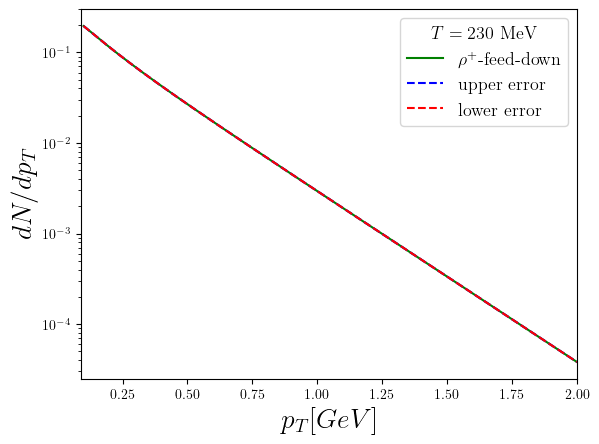

In [18]:
%matplotlib inline
plt.plot(pT, feedDown_vals[0], color = "green", label = r"$\rho^+$-feed-down")
plt.plot(pT, feedDown_vals[0] + feedDown_vals[1], color = "blue", linestyle = "--", label="upper error")
plt.plot(pT, (feedDown_vals[0] - feedDown_vals[1]), color = "red", linestyle= "--", label ="lower error")
mask = (pT>1.8)
mask2 = (feedDown_vals[0][:]-feedDown_vals[1][:])<0
print(pT[mask2])
#print(feedDown_vals[0][:]-feedDown_vals[1][:])

#plt.plot(pT, 2*feedDown_vals[0], color = "blue")
#plt.plot(pT, feedDown_vals[0] +feedDown_vals[1], linestyle = "--", color = "orange")
#plt.plot(pT, feedDown_vals[0] -feedDown_vals[1], linestyle = "--", color = "orange")
plt.xlim(0.09, 2.0)
plt.yscale("log")
plt.legend(fontsize = 13, title= r"$T = 230$ MeV ", title_fontsize=13, loc = "best")
plt.ylabel(r"$dN/dp_T$", fontsize=20)
plt.xlabel(r"$p_T [GeV]$", fontsize = 20)
plt.show()

In [20]:
pi_zero_thermal = thermaldNadpT(pT, ma, T)
photon_thermal = thermaldNadpT(pT, mb, T)

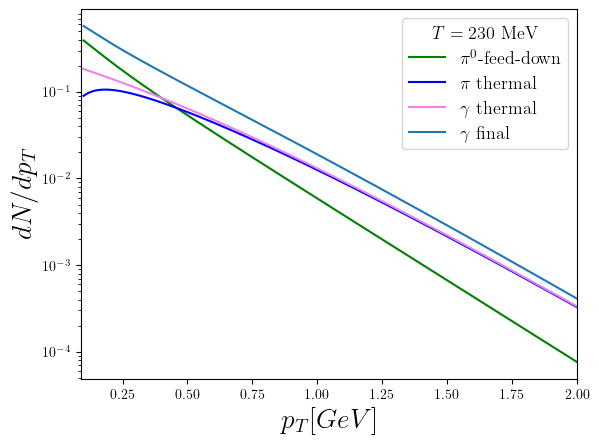

In [22]:
%matplotlib inline
plt.plot(pT, 2*feedDown_vals[0], color = "green", label = r"$\pi^0$-feed-down")
plt.plot(pT,pi_zero_thermal, color = "blue", label = r"$\pi$ thermal ")
plt.plot(pT, photon_thermal, color = "violet", label = r"$\gamma$ thermal ")
plt.plot(pT, photon_thermal + 2*feedDown_vals[0],  label = r"$\gamma$ final ")

#plt.plot(pT, 2*feedDown_vals[0], color = "blue")
#plt.plot(pT, feedDown_vals[0] +feedDown_vals[1], linestyle = "--", color = "orange")
#plt.plot(pT, feedDown_vals[0] -feedDown_vals[1], linestyle = "--", color = "orange")
plt.xlim(0.09, 2)
plt.yscale("log")
plt.legend(fontsize = 13, title= r"$T = 230$ MeV ", title_fontsize=13, loc = "best")
plt.ylabel(r"$dN/dp_T$", fontsize=20)
plt.xlabel(r"$p_T [GeV]$", fontsize = 20)
plt.show()

Ration at p_T =  0.1  is  4.361145323232656
Ration at p_T =  2.0  is  0.23267338311889585


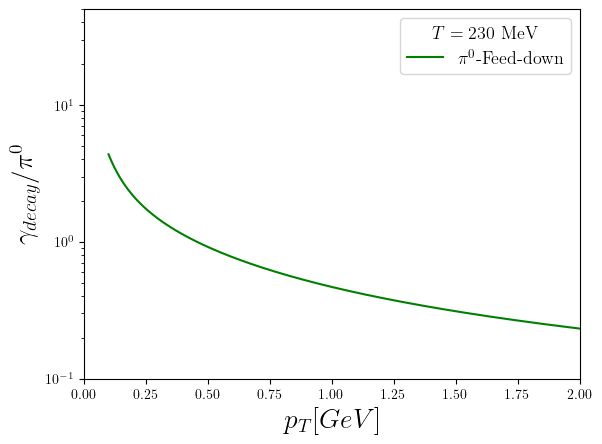

In [24]:
%matplotlib inline
ratio =  2*feedDown_vals[0]/ pi_zero_thermal
ratio_err = 2*feedDown_vals[1]/pi_zero_thermal 
plt.plot(pT, ratio, color = "green", label = r"$\pi^0$-Feed-down")
print("Ration at p_T = ", pT[0], " is ", ratio[0])
print("Ration at p_T = ", pT[-1], " is ", ratio[-1])
plt.ylim(0.1, 50)
plt.xlim(0, 2)
plt.yscale("log")
plt.legend(fontsize = 13, title= r"$T = 230$ MeV ", title_fontsize=13, loc = "best")
plt.ylabel(r"$\gamma_{decay}/\pi^0$", fontsize=20)
plt.xlabel(r"$p_T [GeV]$", fontsize = 20)
plt.show()

### Particle Conservation in massless case

To compute the final particle number from our implementation it is suficcient to integrate the spectrum along the $p_T$ range for which it was computed.

$$ N_i = \int_{p_{min}}^{p_{max}} \frac{dN_i}{dp_T}$$

In [28]:
def partNum(dNdpT, pT, name = "particle"):
    I = integrate.trapezoid(dNdpT, pT)
    print(name, ": particle number N = {:.3}".format(I))
    return I

In [30]:
pT = np.linspace(0.1, 2,500)
#mask = np.isnan(feedDown_vals[0])
#print(feedDown_vals[0])
#print(mask)
n_gammaThermal = partNum(photon_thermal, pT, "gamma - initial")
n_pizero = partNum(pi_zero_thermal, pT, "pi - initial")
n_gamma_decay = partNum(feedDown_vals[0], pT, "gamma - decay")
print(r"N_{{pi}} - N_{{photon}} = {:.3}".format(n_pizero- n_gamma_decay))
print("Missing photons - decay = {:.3}%".format((n_pizero- n_gamma_decay)/n_pizero*100))

gamma - initial : particle number N = 0.0663
pi - initial : particle number N = 0.0541
gamma - decay : particle number N = 0.039
N_{pi} - N_{photon} = 0.0152
Missing photons - decay = 28.0%


## Testing massive case

For this test we will concentrate on the process $\rho^+ \to \pi^+ + \pi^0$ 

In [34]:
ma = 0.7711
mb = 0.13957
mc = 0.13498
b = 1
T = 0.230
ini_args = (ma,T)
pT = np.linspace(0.1, 3,100)
feedDown_vals = getFeedDown_anadNa_safe(pT, ma, mb, mc, b, thermaldNadpT, ini_args,EpsRel = 1e-4, Debug =  False)

C:\Users\magnu\AppData\Local\Temp\ipykernel_16504\3210941571.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r, err = integrate.quad(func, qmin, qmax, epsrel = eepsrel, epsabs= 1e-10, limit = 200)
C:\Users\magnu\AppData\Local\Temp\ipykernel_16504\3210941571.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r, err = integrate.quad(func, qmin, qmax, epsrel = eepsrel, epsabs= 1e-10, limit = 200)
C:\Users\magnu\AppData\Local\Temp\ipykernel_16504\3210941571.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  r, err = integrate.quad(func, qmin, qmax, epsrel = eepsrel, epsabs= 1e-10, limit = 200)
C:\Users\magnu\AppData\Local\Te

[]


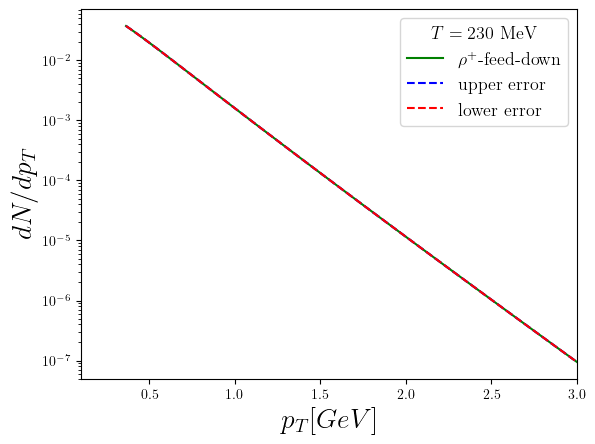

In [36]:
%matplotlib inline
plt.plot(pT, feedDown_vals[0], color = "green", label = r"$\rho^+$-feed-down")
plt.plot(pT, feedDown_vals[0] + feedDown_vals[1], color = "blue", linestyle = "--", label="upper error")
plt.plot(pT, feedDown_vals[0] - feedDown_vals[1], color = "red", linestyle= "--", label ="lower error")
mask = (pT>1.8)
mask2 = (feedDown_vals[0][:]-feedDown_vals[1][:])<0
print(pT[mask2])
#print(feedDown_vals[0][:]-feedDown_vals[1][:])

#plt.plot(pT, 2*feedDown_vals[0], color = "blue")
#plt.plot(pT, feedDown_vals[0] +feedDown_vals[1], linestyle = "--", color = "orange")
#plt.plot(pT, feedDown_vals[0] -feedDown_vals[1], linestyle = "--", color = "orange")
plt.xlim(0.1, 3)
plt.yscale("log")
plt.legend(fontsize = 13, title= r"$T = 230$ MeV ", title_fontsize=13, loc = "best")
plt.ylabel(r"$dN/dp_T$", fontsize=20)
plt.xlabel(r"$p_T [GeV]$", fontsize = 20)
plt.show()

In [38]:
rho_plus_thermal = thermaldNadpT(pT, ma, T)
pi_plus_thermal = thermaldNadpT(pT, mb, T)

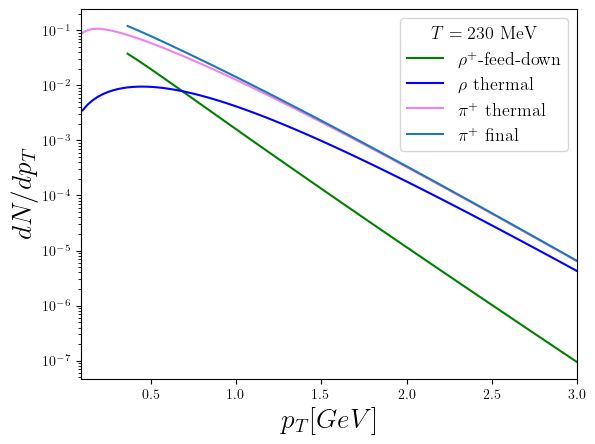

In [40]:
%matplotlib inline
plt.plot(pT, feedDown_vals[0], color = "green", label = r"$\rho^+$-feed-down")
plt.plot(pT,rho_plus_thermal, color = "blue", label = r"$\rho$ thermal ")
plt.plot(pT, pi_plus_thermal, color = "violet", label = r"$\pi^+$ thermal ")
plt.plot(pT, pi_plus_thermal + feedDown_vals[0],  label = r"$\pi^+$ final ")

#plt.plot(pT, 2*feedDown_vals[0], color = "blue")
#plt.plot(pT, feedDown_vals[0] +feedDown_vals[1], linestyle = "--", color = "orange")
#plt.plot(pT, feedDown_vals[0] -feedDown_vals[1], linestyle = "--", color = "orange")
plt.xlim(0.09, 3)
plt.yscale("log")
plt.legend(fontsize = 13, title= r"$T = 230$ MeV ", title_fontsize=13, loc = "best")
plt.ylabel(r"$dN/dp_T$", fontsize=20)
plt.xlabel(r"$p_T [GeV]$", fontsize = 20)
plt.show()

### Particle number conservation

In [43]:
mask = (False ==(np.isnan(feedDown_vals[0])))
#print(mask)
#print(feedDown_vals[0])
#print(mask)
n_piThermal = partNum(pi_plus_thermal[mask], pT[mask], "pi - initial")
n_rhop = partNum(rho_plus_thermal[mask], pT[mask], "rho - initial")
n_pi_decay = partNum(feedDown_vals[0][mask], pT[mask], "pi - decay")
print( "pi + rho - initial : particle number N = {:.3}".format(n_piThermal + n_rhop))
print( "pi - final : particle number N = {:.3}".format(n_piThermal + n_pi_decay))
print(r"N_{{rho}} - N_{{pi}} Final :  {:.3}".format(n_rhop- n_pi_decay))
print("Missing pi - decay = {:.3}%".format((n_rhop- n_pi_decay)/n_rhop*100))

pi - initial : particle number N = 0.0284
rho - initial : particle number N = 0.00618
pi - decay : particle number N = 0.00773
pi + rho - initial : particle number N = 0.0346
pi - final : particle number N = 0.0362
N_{rho} - N_{pi} Final :  -0.00155
Missing pi - decay = -25.0%


## Other plots

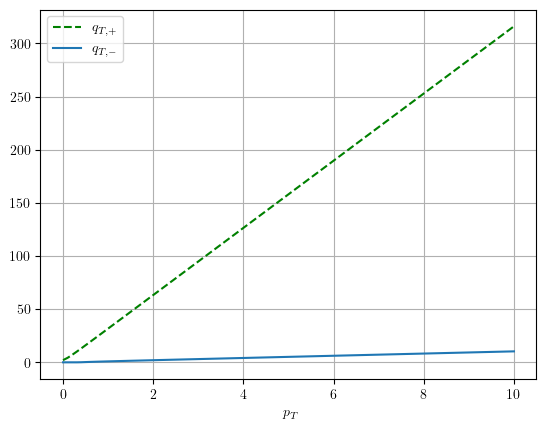

In [45]:
#ma = 0.14
#mc = 0.0
#mb = 0.0
ma = 0.7711
mb = 0.13498
mc = 0.13498
parray = np.linspace(0,10, 100)
plt.grid()
qp_values = np.zeros_like(parray)
qm_values = np.zeros_like(parray)
for i, p in enumerate(parray):
    qp_values[i] = get_qTplus(ma, mb, mc, p)
    qm_values[i] = max(get_qTminus(ma, mb, mc, p),0)
#print(qm_values)
#print(qp_values)
plt.plot(parray, qp_values, linestyle = "--", color="green", label = r"$q_{T,+}$")
plt.plot(parray, qm_values, label = r"$q_{T,-}$")
plt.xlabel(r"$p_T$")
plt.legend()
plt.show()

C:\Users\magnu\AppData\Local\Temp\ipykernel_32564\871080949.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  return (ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_32564\871080949.py:80: RuntimeWarning: divide by zero encountered in scalar divide
  return (-ma*Estar + mqT*mpT)/pT/qT


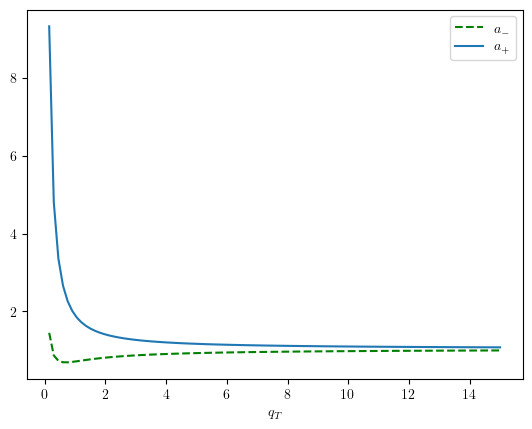

In [830]:
#ma = 0.14
#mb = 0.0
#mc = 0.0
ma = 0.7711
mb = 0.13957
mc = 0.13498
b = 1
pT = 0.5
qT = np.linspace(0,3, 100)
am_values = np.zeros_like(qT)
ap_values = np.zeros_like(qT)
for i, q in enumerate(qT):
    ap_values[i] = getAplus(q, ma, mb, mc, pT)
    am_values[i] = max(getAminus(q, ma, mb, mc, pT),0)

plt.plot(qT, am_values, color = "green", linestyle = "--", label = r"$a_{-}$")
plt.plot(qT, ap_values,label = r"$a_{+}$" )
plt.xlabel(r"$q_T$")
plt.legend()
plt.show()

C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\3251369846.py:77: RuntimeWarning: divide by zero encountered in divide
  return (-ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\3251369846.py:70: RuntimeWarning: divide by zero encountered in divide
  return (ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\169502921.py:38: RuntimeWarning: invalid value encountered in add
  argument = (1- am)*(ap-1)/(2*(am+ap))
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\169502921.py:38: RuntimeWarning: invalid value encountered in divide
  argument = (1- am)*(ap-1)/(2*(am+ap))


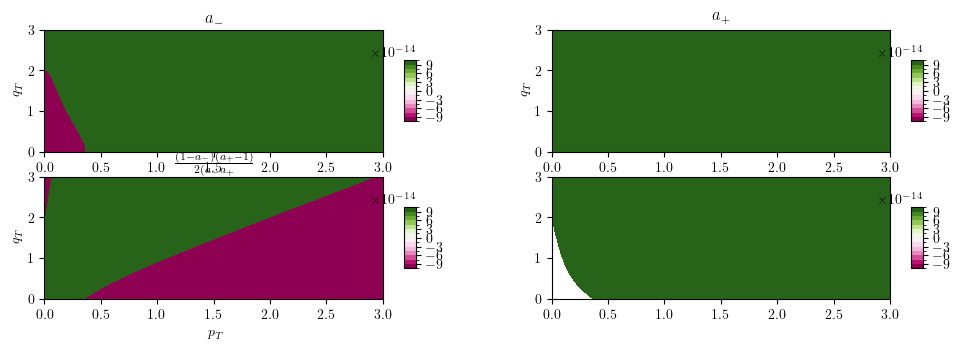

In [457]:
%matplotlib inline
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
ma = 0.7711
mb = 0.13957
mc = 0.13498
b = 1
pT = slice(0, 3 + 3/1000, 3/1000)
qT = slice(0, 3 + 3/1000, 3/1000)
pT, qT = np.mgrid[pT, qT]
am = getAminus(qT, ma, mb, mc, pT)
am = am[:-1, :-1]
ap = getAplus(qT, ma, mb, mc, pT)
ap = ap[:-1, :-1]

fig, ax1 = plt.subplots(2,2, figsize=(12, 3.5))
cmap = plt.get_cmap('PiYG')

#plotting am
levels = MaxNLocator(nbins=15).tick_values(am.min(), am.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im_am = ax1[0,0].pcolormesh(pT, qT, am, cmap = cmap, norm = norm)
ax1[0,0].set_title(r"$a_{-}$")
ax1[0,0].set_xlabel(r"$p_T$")
ax1[0,0].set_ylabel(r"$q_T$")
fig.colorbar(im_am, ax = ax1[0,0], shrink = 0.5, aspect = 5)

#plotting ap
levels = MaxNLocator(nbins=15).tick_values(ap.min(), ap.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im_ap = ax1[0,1].pcolormesh(pT, qT, ap, cmap = cmap, norm = norm)
ax1[0,1].set_title(r"$a_{+}$")
ax1[0,1].set_xlabel(r"$p_T$")
ax1[0,1].set_ylabel(r"$q_T$")
fig.colorbar(im_ap, ax = ax1[0,1], shrink = 0.5, aspect = 5)

#plotting argument
argument = (1- am)*(ap-1)/(2*(am+ap))
levels = MaxNLocator(nbins=15).tick_values(argument.min(), argument.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im_argument = ax1[1,0].pcolormesh(pT, qT, argument, cmap = cmap, norm = norm)
fig.colorbar(im_argument, ax = ax1[1,0], shrink = 0.5, aspect = 5)
ax1[1,0].set_title(r"$\frac{(1-a_{-})(a_{+} -1)}{2(a_{-}a_{+}}$")
ax1[1,0].set_xlabel(r"$p_T$")
ax1[1,0].set_ylabel(r"$q_T$")

#plotting elliptick
elliptick = ellipk(argument)
levels = MaxNLocator(nbins=15).tick_values(elliptick.min(), elliptick.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im_elliptick = ax1[1,1].pcolormesh(pT, qT, elliptick, cmap = cmap, norm = norm)
fig.colorbar(im_elliptick, ax = ax1[1,1], shrink = 0.5, aspect = 5)


plt.show()

C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\3251369846.py:77: RuntimeWarning: divide by zero encountered in divide
  return (-ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\3251369846.py:70: RuntimeWarning: divide by zero encountered in divide
  return (ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:25: RuntimeWarning: invalid value encountered in add
  argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:25: RuntimeWarning: invalid value encountered in divide
  argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:25: RuntimeWarning: invalid value encountered in sqrt
  argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:26: RuntimeWarning: invalid value encountered in arcsin
  phi = np.arcs

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:62: RuntimeWarning: invalid value encountered in add
  denom = -1*(ap -1)*(am + ap)/(am+1)**2
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:62: RuntimeWarning: invalid value encountered in divide
  denom = -1*(ap -1)*(am + ap)/(am+1)**2
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:63: RuntimeWarning: invalid value encountered in sqrt
  phiIntegral = np.sqrt(2)*np.sqrt(-am - 1)*(-1*(am +1))**(-3/2)*np.sqrt(ap-1)*ellipkinc(phi, m)/np.sqrt(denom)
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:63: RuntimeWarning: invalid value encountered in power
  phiIntegral = np.sqrt(2)*np.sqrt(-am - 1)*(-1*(am +1))**(-3/2)*np.sqrt(ap-1)*ellipkinc(phi, m)/np.sqrt(denom)
C:\Users\magnu\AppData\Local\Temp\ipykernel_54608\1702198156.py:63: RuntimeWarning: invalid value encountered in multiply
  phiIntegral = np.sqrt(2)*np.sqrt(-am - 1)*(-1*(am +1))**(-3/2)*np.sqrt(ap-1)*ellipkinc(phi, m)/n

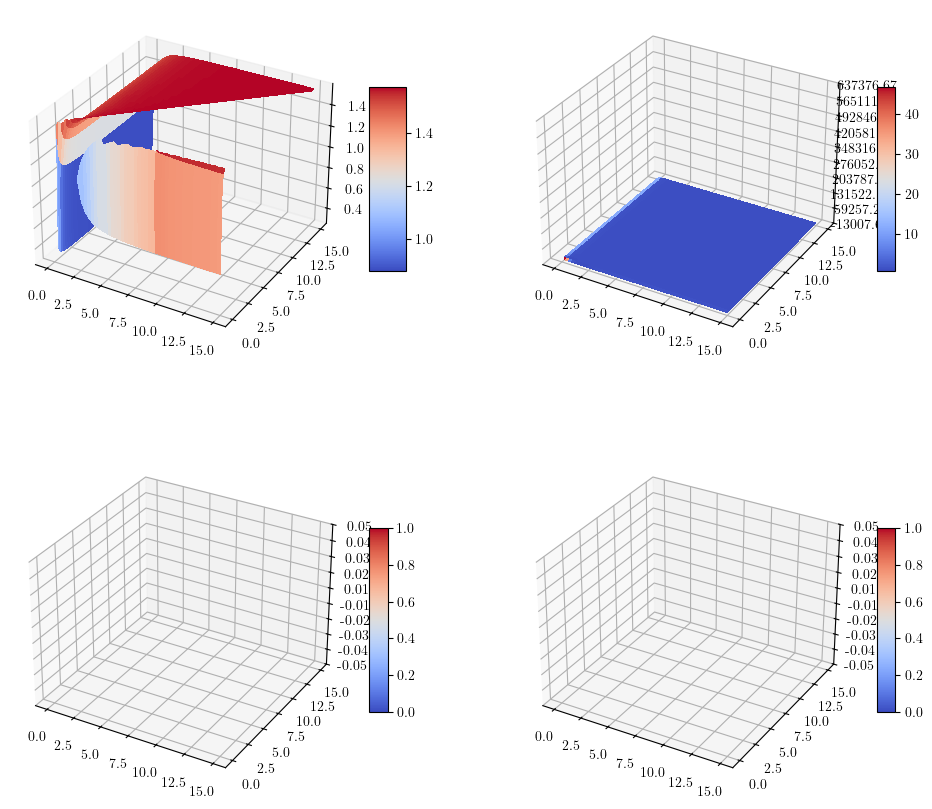

In [407]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(12, 10.5))

#pT = np.linspace(0,15,100)
#qT = np.linspace(0,15, 100)
#ma = 0.14
#mb = 0.0
#mc = 0.0
ma = 0.7711
mb = 0.13957
mc = 0.13498
b = 1
qT, pT= np.meshgrid(np.arange(0,15, 15/1000),np.arange(0,15, 15/1000))
am = getAminus(qT, ma, mb, mc, pT)
#am = am[:-1, :-1]
ap = getAplus(qT, ma, mb, mc, pT)
#ap = ap[:-1, :-1]

#plotting phi
ax1 = fig.add_subplot(2,2,1, projection='3d')
argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
phi = np.arcsin(argument)
surf_phi = ax1.plot_surface(qT, pT, phi, cmap = cm.coolwarm, linewidth = 0, antialiased = False)


#levels = MaxNLocator(nbins=15).tick_values(phi.min(), phi.max())
#cmap = plt.get_cmap('PiYG')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#phi_im = ax1[0][0].pcolormesh(qT, pT, phi, cmap = cmap, norm = norm)

fig.colorbar(surf_phi, ax = ax1, shrink = 0.5, aspect = 5)

#plotting m 
m = ((am+1)*(ap+1)/(2*(am + ap)))**2
ax1 = fig.add_subplot(2,2,2, projection='3d')
surf_m = ax1.plot_surface(qT, pT, m, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#ax1.set_zlim(m.min(), m.max())
fig.colorbar(surf_m, ax = ax1, shrink = 0.5, aspect = 10)
#m = ((am+1)*(ap+1)/(2*(am + ap)))**2
#levels = MaxNLocator(nbins=20).tick_values(m.min(), m.max())
#cmap = plt.get_cmap('PiYG')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#m_im = ax1[0][1].pcolormesh(qT, pT, m, cmap = cmap, norm = norm)
#fig.colorbar(m_im, ax = ax1[0][1])

#plotting elliptic
elliptic = ellipkinc(phi,m)
print(elliptic)
ax1 = fig.add_subplot(2,2,3, projection='3d')
surf_elliptic = ax1.plot_surface(qT, pT, elliptic, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf_elliptic, ax = ax1, shrink = 0.5, aspect = 10)

#plotting phiintegral 
denom = -1*(ap -1)*(am + ap)/(am+1)**2
phiIntegral = np.sqrt(2)*np.sqrt(-am - 1)*(-1*(am +1))**(-3/2)*np.sqrt(ap-1)*ellipkinc(phi, m)/np.sqrt(denom)
ax1 = fig.add_subplot(2,2,4, projection='3d')
surf_int = ax1.plot_surface(qT, pT, phiIntegral, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf_int, ax = ax1, shrink = 0.5, aspect = 10)

plt.show()


C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return (-ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  return (ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:97: RuntimeWarning: invalid value encountered in scalar add
  if ((am + ap)/(ap*am + am + ap + 1))<0:
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:101: RuntimeWarning: invalid value encountered in scalar add
  argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:107: RuntimeWarning: invalid value encountered in scalar add
  m = ((am+1)*(ap+1)/(2*(am + ap)))**2
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:108: RuntimeWarning: invalid value encountered in scalar add
  denom = -1*(ap -1)*(am + ap)/(

[0.         0.00398205 0.00796409 0.01194614 0.01592818 0.01991023
 0.02389228 0.02787432 0.03185637 0.03583841 0.03982046 0.04380251
 0.04778455 0.0517666  0.05574864 0.05973069 0.06371274 0.06769478
 0.07167683 0.07565887 0.07964092 0.08362297 0.08760501 0.09158706
 0.09556911 0.09955115 0.1035332  0.10751524 0.11149729 0.11547934
 0.11946138 0.12344343 0.12742547 0.13140752 0.13538957 0.13937161
 0.14335366 0.1473357  0.15131775 0.1552998  0.15928184 0.16326389
 0.16724593 0.17122798 0.17521003 0.17919207 0.18317412 0.18715616
 0.19113821 0.19512026 0.1991023  0.20308435 0.20706639 0.21104844
 0.21503049 0.21901253 0.22299458 0.22697662 0.23095867 0.23494072
 0.23892276 0.24290481 0.24688685 0.2508689  0.25485095 0.25883299
 0.26281504 0.26679709 0.27077913 0.27476118 0.27874322 0.28272527
 0.28670732 0.29068936 0.29467141 0.29865345 0.3026355  0.30661755
 0.31059959 0.31458164 0.31856368 0.32254573 0.32652778 0.33050982
 0.33449187 0.33847391 0.34245596 0.34643801 0.35042005 0.3544

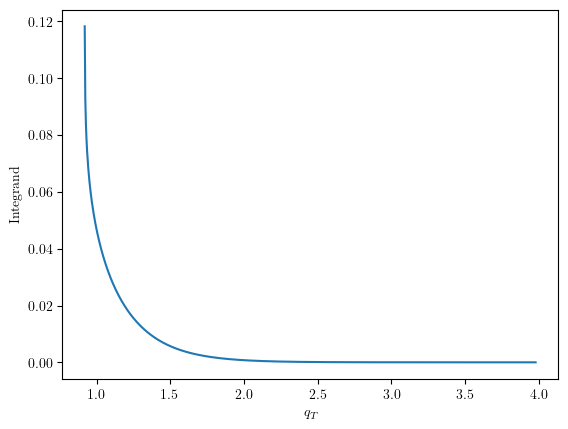

In [320]:
ma = 0.7711
mb = 0.13957
mc = 0.13498
b = 1
T = 0.230
ini_args = (ma,T)
p = 0.1
qmin = max(get_qTminus(ma, mb, mc, p), 0)
qmax= get_qTplus(ma, mb, mc, p)
args = (b, ma, mb, mc,p, False)
qT_array = np.linspace(qmin, qmax, 1000)
vals = np.zeros_like(qT_array)
for i,q in enumerate(qT_array):
    vals[i] = integrand_factor_massive(q, *args) * thermaldNadpT(q, *ini_args) 
print(qT_array[np.isnan(vals)])
plt.plot(qT_array, vals)
plt.ylabel("Integrand")
plt.xlabel(r"$q_T$")
plt.show()

C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return (-ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  return (ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:97: RuntimeWarning: invalid value encountered in scalar add
  if ((am + ap)/(ap*am + am + ap + 1))<0:
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:101: RuntimeWarning: invalid value encountered in scalar add
  argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:107: RuntimeWarning: invalid value encountered in scalar add
  m = ((am+1)*(ap+1)/(2*(am + ap)))**2
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:108: RuntimeWarning: invalid value encountered in scalar add
  denom = -1*(ap -1)*(am + ap)/(

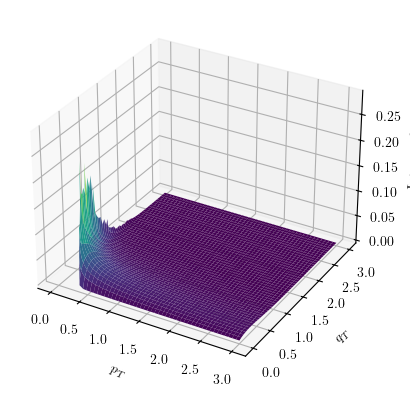

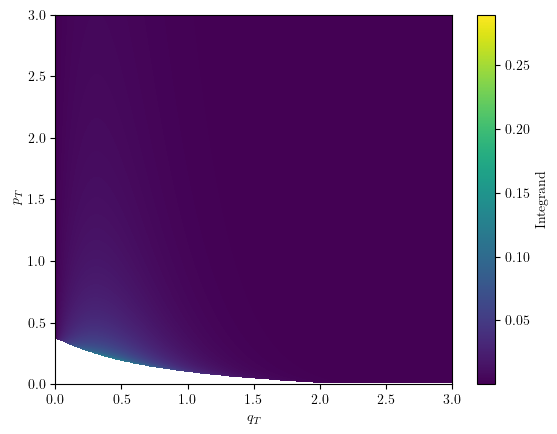

In [375]:
%matplotlib inline
ma = 0.7711
mb = 0.13957
mc = 0.13498
b = 1
T = 0.230
ini_args = (ma,T)
pT_array = np.linspace(0.0, 3.0, 1000)
qT_array = np.linspace(0.0, 3.0, 1000)

Z = np.zeros((len(pT_array), len(qT_array)))

for i, p in enumerate(pT_array):
    args = (b, ma, mb, mc, p, False)
    for j, q in enumerate(qT_array):
        Z[i, j] = integrand_factor_massive(q, *args) * thermaldNadpT(q, *ini_args)

#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

P, Q = np.meshgrid(pT_array, qT_array, indexing="ij")
ax.plot_surface(P, Q, Z, cmap="viridis")

ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$q_T$")
ax.set_zlabel("Integrand")
plt.show()

# 2D projection
plt.imshow(Z, extent=[qT_array.min(), qT_array.max(), pT_array.min(), pT_array.max()],
           origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(label="Integrand")
plt.xlabel(r"$q_T$")
plt.ylabel(r"$p_T$")
plt.show()


C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return (-ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  return (ma*Estar + mqT*mpT)/pT/qT
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:97: RuntimeWarning: invalid value encountered in scalar add
  if ((am + ap)/(ap*am + am + ap + 1))<0:
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:101: RuntimeWarning: invalid value encountered in scalar add
  argument = np.sqrt(2)*np.sqrt((am + ap)/(ap*am + am + ap + 1))
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:107: RuntimeWarning: invalid value encountered in scalar add
  m = ((am+1)*(ap+1)/(2*(am + ap)))**2
C:\Users\magnu\AppData\Local\Temp\ipykernel_8240\2838371889.py:108: RuntimeWarning: invalid value encountered in scalar add
  denom = -1*(ap -1)*(am + ap)/(

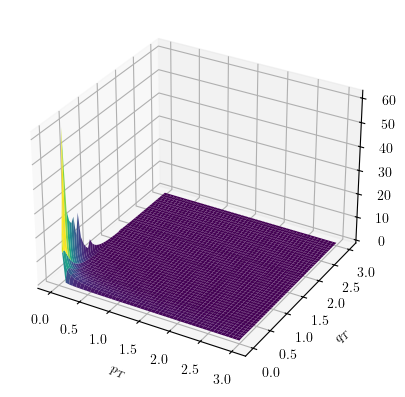

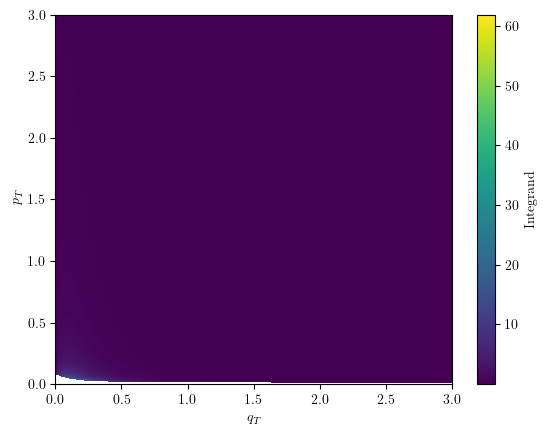

In [376]:
#ma = 0.13497
ma = 0.14
T = 0.230
ini_args = (ma,T)
mb = 0.0
mc = 0.0
#b = 0.98823
b = 1
ini_args = (ma,T)
pT_array = np.linspace(0.0, 3.0, 1000)
qT_array = np.linspace(0.0, 3.0, 1000)

Z = np.zeros((len(pT_array), len(qT_array)))

for i, p in enumerate(pT_array):
    args = (b, ma, mb, mc, p, False)
    for j, q in enumerate(qT_array):
        Z[i, j] = integrand_factor_massive(q, *args) * thermaldNadpT(q, *ini_args)

#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

P, Q = np.meshgrid(pT_array, qT_array, indexing="ij")
ax.plot_surface(P, Q, Z, cmap="viridis")

ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$q_T$")
ax.set_zlabel("Integrand")
plt.show()

# 2D projection
plt.imshow(Z, extent=[qT_array.min(), qT_array.max(), pT_array.min(), pT_array.max()],
           origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(label="Integrand")
plt.xlabel(r"$q_T$")
plt.ylabel(r"$p_T$")
plt.show()
